In [1]:

import numpy as np
import matplotlib.pyplot as plt
from blackscholes import BlackScholesCall, BlackScholesPut
from data import get_historical_prices, calculate_log_returns, set_fred_api_key, get_risk_free_rate

In [2]:
set_fred_api_key("09076f364bb3c14142005a12bb7ef7a3")

In [3]:
apple = get_historical_prices(symbol="AAPL")
print(apple.head())

                  open        high         low       close    volume  dividend
date                                                                          
2024-07-03  220.000000  221.550003  219.029999  221.550003  37369800       0.0
2024-07-05  221.649994  226.449997  221.649994  226.339996  60412400       0.0
2024-07-08  227.089996  227.850006  223.250000  227.820007  59085900       0.0
2024-07-09  227.929993  229.399994  226.369995  228.679993  48076100       0.0
2024-07-10  229.300003  233.080002  229.250000  232.979996  62627700       0.0


In [4]:
log_returns, mean_return, std_return = calculate_log_returns(apple)
    
print(f"Mean daily log return: {mean_return:.6f}")
print(f"Standard deviation of daily log returns: {std_return:.6f}")
print("\nFirst few log returns:")
print(log_returns.head())

Mean daily log return: -0.000147
Standard deviation of daily log returns: 0.020092

First few log returns:
date
2024-07-05    0.021390
2024-07-08    0.006518
2024-07-09    0.003768
2024-07-10    0.018629
2024-07-11   -0.023495
Name: close, dtype: float64


In [5]:
# Parameters
S0 = 100      # Initial stock price
K = 95       # Strike price
T = 1.0       # Time to maturity (1 year)
Nsteps = 10000
mu = mean_return  # Drift
sigma = std_return * np.sqrt(252)   # Volatility
n_sim = 1000 # Number of simulations
option_type = 'call' # 'call' or 'put'
r = get_risk_free_rate() # Risk-free rate

0.3189429577163038


In [6]:
# Create the Standard Normal Distribution
Z = np.random.normal(loc=0, scale=1, size=(n_sim, Nsteps))

# Define the time step size and t-axis
interval = [0.0, T]
dt = (interval[1] - interval[0]) / (Nsteps)
t_axis = np.linspace(interval[0], interval[1], Nsteps + 1)


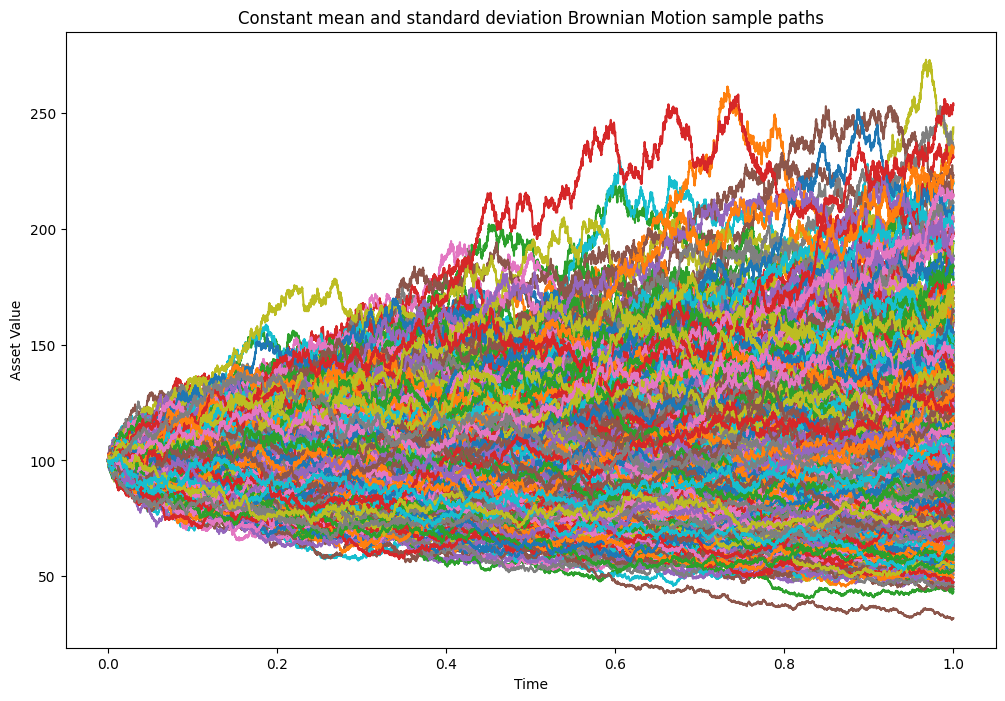

In [7]:
X = np.zeros((n_sim, Nsteps + 1))
X[:, 0] = S0
for i in range(Nsteps):
    X[:, i + 1] = X[:, i] * np.exp((r - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * Z[:, i])

# Plot these paths
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
for path in range(n_sim):
    ax.plot(t_axis, X[path, :])
ax.set_title("Constant mean and standard deviation Brownian Motion sample paths")
ax.set_xlabel("Time")
ax.set_ylabel("Asset Value")
plt.show()

In [8]:
#Heston Model
v0 = sigma**2      # Initial variance
k = 4    # Speed of mean reversion
theta = sigma**2     # Long-term variance
sigma_v = 0.05        # Vol of vol
rho = -0.5       # Correlation
mu = np.array([0,0]) # Mean for the correlated Brownian motions
cov = np.array([[1, rho] , [rho , 1]]) # Covariance matrix for the correlated Brownian motions


In [9]:
dt = T / Nsteps

# Initializing
S = np.zeros((n_sim, Nsteps + 1))
v = np.zeros((n_sim, Nsteps + 1))
S[:, 0] = S0
v[:, 0] = v0

for t in range(Nsteps):
    # Create the Brownian motions with correlation rho
    B_t = np.random.multivariate_normal(mu, cov, size=n_sim)

    # Asset price for Heston Model
    S[:, t + 1] = S[:, t] * np.exp((r - 0.5 * v[:, t]) * dt + np.sqrt(v[:, t] * dt) * B_t[:, 0])
    # Variance for Heston Model
    v[:, t + 1] = v[:, t] + k * (theta - v[:, t]) * dt + sigma_v * np.sqrt(v[:, t] * dt) * B_t[:, 1]
    v[:, t + 1] = np.maximum(v[:, t + 1], 0)  # make sure variance is positive



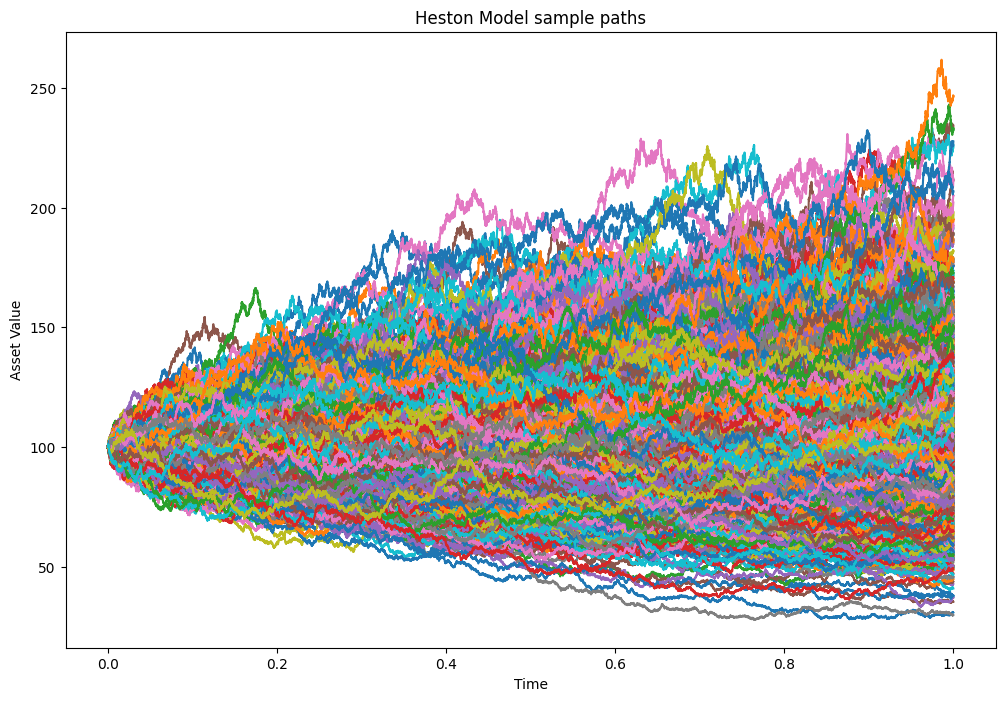

In [10]:
# Plot these paths
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
for path in range(n_sim):
    ax.plot(t_axis, S[path, :])
ax.set_title("Heston Model sample paths")
ax.set_xlabel("Time")
ax.set_ylabel("Asset Value")
plt.show()

In [11]:
if option_type == 'call':
    value = np.maximum(X[:, -1] - K, 0)
else:
    value = np.maximum(K - X[:, -1], 0)

monte_carlo_estimate = np.mean(value) * np.exp(-r * T)
print(f"Monte Carlo estimate: {monte_carlo_estimate:.4f}")

Monte Carlo estimate: 16.7434


In [12]:
if option_type == 'call':
    call = BlackScholesCall(S=S0, K=K, T=T, r=r, sigma=sigma, q=0)
    print(f"Black-Scholes Call Price: {call.price():.4f}")
else:
    put = BlackScholesPut(S=S0, K=K, T=T, r=r, sigma=sigma, q=0)
    print(f"Black-Scholes Put Price: {put.price():.4f}")

Black-Scholes Call Price: 17.1750


In [13]:
if option_type == 'call':
    heston_value = np.maximum(S[:, -1] - K, 0)
else:
    heston_value = np.maximum(K - S[:, -1], 0)

heston_estimate = np.mean(heston_value) * np.exp(-r * T)
print(f"Heston estimate: {heston_estimate:.4f}")

Heston estimate: 16.7921
